In [71]:
# import libraries
import numpy as np
import pandas as pd
import swat as sw
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import warnings
warnings.filterwarnings("ignore")

In [72]:
# load Credit Card data
Bank_Data = pd.read_csv('../gan-testing/data/BankLoan.csv')
Bank_discrete_columns ="Family,Education,ID,ZIP Code,Securities Account,CD Account,Online,CreditCard,Personal Loan".split(',')
Bank_Data

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


In [73]:
Bank_Data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [74]:
# pre-process data: Replacing the negative values with the mean value of the column
exp_med = Bank_Data.loc[:,"Experience"].median()
Bank_Data.loc[:, 'Experience'].replace([-1, -2, -3], [exp_med, exp_med, exp_med], inplace=True)
any(Bank_Data['Experience'] < 0)

False

In [75]:
# check label event balance
df=Bank_Data.loc[:,'Personal Loan']
df.value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

In [76]:
Bank_Data = Bank_Data.drop(["ID", "Experience"],axis=1)
Bank_X = Bank_Data.drop(["Personal Loan"],axis=1)
orig_X, orig_y = Bank_X,Bank_Data.loc[:,"Personal Loan"]
print(orig_y.value_counts())

0    4520
1     480
Name: Personal Loan, dtype: int64


In [77]:
from sklearn.model_selection import train_test_split

orig_X_train, orig_X_test, orig_y_train, orig_y_test = train_test_split(orig_X, orig_y, test_size=0.3, random_state=123)
my_data1_train = pd.concat([orig_X_train,orig_y_train],axis=1)
my_data1_test = pd.concat([orig_X_test,orig_y_test],axis=1)
#my_data1_test.describe()
orig_y_train = orig_y_train.astype('int')
orig_y_test = orig_y_test.astype('int')

In [78]:
# train ML models on the train set of the original data
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
names = ["Decision Tree","Linear SVM", "Random Forest", "Logistic Regression","MLP"]

classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

In [39]:
print('ML scores for the original data:')
for name, clf in zip(names, classifiers):
    clf.fit(orig_X_train, orig_y_train)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)


ML scores for the original data:
Decision Tree Acc:  0.9826666666666667 f-1:  0.9097222222222222 AUC: 0.97750450213472
Linear SVM Acc:  0.7913333333333333 f-1:  0.14246575342465753 AUC: 0.5460229457113372
Random Forest Acc:  0.9866666666666667 f-1:  0.9280575539568345 AUC: 0.9970280852269278
Logistic Regression Acc:  0.9106666666666666 f-1:  0.4017857142857143 AUC: 0.9258463001558043
MLP Acc:  0.9026666666666666 f-1:  0.0 AUC: 0.8825600453248619


In [79]:
# # now input the data to CPCTGAN and train
# cov_discrete_columns = cov_discrete_columns[:-1]
Bank_discrete_columns

['Family',
 'Education',
 'ID',
 'ZIP Code',
 'Securities Account',
 'CD Account',
 'Online',
 'CreditCard',
 'Personal Loan']

In [80]:
# get the train data for gan with same seed as the ML utility
GAN_X = Bank_Data.drop(["Personal Loan"],axis=1)
GAN_orig_X, GAN_orig_y = GAN_X,Bank_Data.loc[:,"Personal Loan"]

In [81]:
from sklearn.model_selection import train_test_split

GAN_X_train, GAN_X_test, GAN_y_train, GAN_y_test = train_test_split(GAN_orig_X, GAN_orig_y, test_size=0.3, random_state=123)
GAN_data_train = pd.concat([GAN_X_train,GAN_y_train],axis=1)
GAN_data_test = pd.concat([GAN_X_test,GAN_y_test],axis=1)
#my_data1_test.describe()

In [82]:
Bank_discrete_columns.remove("ID")

In [83]:
Bank_discrete_columns

['Family',
 'Education',
 'ZIP Code',
 'Securities Account',
 'CD Account',
 'Online',
 'CreditCard',
 'Personal Loan']

In [84]:
GAN_data_train.columns

Index(['Age', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage',
       'Securities Account', 'CD Account', 'Online', 'CreditCard',
       'Personal Loan'],
      dtype='object')

In [85]:
s = sw.CAS('dl2073.clstr.rnd.sas.com',33789)

In [86]:
s.loadactionset('generativeAdversarialNet')

NOTE: Added action set 'generativeAdversarialNet'.


[actionset]

 'generativeAdversarialNet'

+ Elapsed: 0.375s, user: 3.37s, sys: 2.87s, mem: 0.222mb

In [87]:
s.upload(GAN_data_train, casout=dict(name='GAN_data_train', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table GAN_DATA_TRAIN in caslib CASUSER(alphel).
NOTE: The table GAN_DATA_TRAIN has been created in caslib CASUSER(alphel) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(alphel)'

[tableName]

 'GAN_DATA_TRAIN'

[casTable]

 CASTable('GAN_DATA_TRAIN', caslib='CASUSER(alphel)')

+ Elapsed: 0.017s, user: 0.0122s, sys: 0.0163s, mem: 58.4mb

In [88]:
cen = pd.read_csv("../gan-testing/data/loan_centroids.csv")
s.upload(cen, casout=dict(name='cen', replace=True))
cen

NOTE: Cloud Analytic Services made the uploaded file available as table CEN in caslib CASUSER(alphel).
NOTE: The table CEN has been created in caslib CASUSER(alphel) from binary data uploaded to Cloud Analytic Services.


,VarName,Centroid_i,weight,Mean,Std
0,Securities Account,1,0.10600,1.00,0.05
1,Securities Account,2,0.89400,0.00,0.01
2,Age,1,1.00000,45.18,11.33
3,Income,1,0.19637,66.69,20.97
4,Income,2,0.19298,55.19,20.89
5,Income,3,0.13987,124.10,40.84
6,Income,4,0.31037,29.73,11.63
7,Income,5,0.16041,137.56,36.75
8,ZIP Code,1,0.36276,93163.43,1756.91
9,ZIP Code,2,0.32950,92925.98,1798.19


In [ ]:
results = s.tabularGanTrain(
table = {"name":"GAN_data_train"},
    centroidsTable= "cen",
    gpu = 1,
    nominals = ['Family', 'Education', 'ZIP Code', 'Securities Account', 'CD Account', 'Online', 'CreditCard', 'Personal Loan'],
    optimizerAe ={"method":'ADAM',"numEpochs":500},
    optimizerGan ={"method":'ADAM',"numEpochs":500},
    seed = 12345,
    scoreSeed = 1234,
    numSamples =200000,
    saveState ={"name":"cpctStore", "replace":True},
    casOut = {"name":"out", "replace":True}
)
results

NOTE: Using device: GPU 0.
NOTE: Epoch i=1, ae_loss=  0.0157.
NOTE: Epoch i=2, ae_loss=  0.0118.
NOTE: Epoch i=3, ae_loss=  0.0101.
NOTE: Epoch i=4, ae_loss=  0.0091.
NOTE: Epoch i=5, ae_loss=  0.0086.
NOTE: Epoch i=6, ae_loss=  0.0082.
NOTE: Epoch i=7, ae_loss=  0.0075.
NOTE: Epoch i=8, ae_loss=  0.0072.
NOTE: Epoch i=9, ae_loss=  0.0069.
NOTE: Epoch i=10, ae_loss=  0.0068.
NOTE: Epoch i=11, ae_loss=  0.0068.
NOTE: Epoch i=12, ae_loss=  0.0061.
NOTE: Epoch i=13, ae_loss=  0.0063.
NOTE: Epoch i=14, ae_loss=  0.0060.
NOTE: Epoch i=15, ae_loss=  0.0059.
NOTE: Epoch i=16, ae_loss=  0.0057.
NOTE: Epoch i=17, ae_loss=  0.0057.
NOTE: Epoch i=18, ae_loss=  0.0059.
NOTE: Epoch i=19, ae_loss=  0.0055.
NOTE: Epoch i=20, ae_loss=  0.0054.
NOTE: Epoch i=21, ae_loss=  0.0054.
NOTE: Epoch i=22, ae_loss=  0.0054.
NOTE: Epoch i=23, ae_loss=  0.0054.
NOTE: Epoch i=24, ae_loss=  0.0051.
NOTE: Epoch i=25, ae_loss=  0.0051.
NOTE: Epoch i=26, ae_loss=  0.0052.
NOTE: Epoch i=27, ae_loss=  0.0050.
NOTE: Epoc

NOTE: Epoch i=225, ae_loss=  0.0042.
NOTE: Epoch i=226, ae_loss=  0.0043.
NOTE: Epoch i=227, ae_loss=  0.0043.
NOTE: Epoch i=228, ae_loss=  0.0043.
NOTE: Epoch i=229, ae_loss=  0.0042.
NOTE: Epoch i=230, ae_loss=  0.0041.
NOTE: Epoch i=231, ae_loss=  0.0041.
NOTE: Epoch i=232, ae_loss=  0.0043.
NOTE: Epoch i=233, ae_loss=  0.0042.
NOTE: Epoch i=234, ae_loss=  0.0043.
NOTE: Epoch i=235, ae_loss=  0.0042.
NOTE: Epoch i=236, ae_loss=  0.0043.
NOTE: Epoch i=237, ae_loss=  0.0044.
NOTE: Epoch i=238, ae_loss=  0.0043.
NOTE: Epoch i=239, ae_loss=  0.0042.
NOTE: Epoch i=240, ae_loss=  0.0042.
NOTE: Epoch i=241, ae_loss=  0.0043.
NOTE: Epoch i=242, ae_loss=  0.0043.
NOTE: Epoch i=243, ae_loss=  0.0043.
NOTE: Epoch i=244, ae_loss=  0.0043.
NOTE: Epoch i=245, ae_loss=  0.0042.
NOTE: Epoch i=246, ae_loss=  0.0044.
NOTE: Epoch i=247, ae_loss=  0.0043.
NOTE: Epoch i=248, ae_loss=  0.0042.
NOTE: Epoch i=249, ae_loss=  0.0042.
NOTE: Epoch i=250, ae_loss=  0.0042.
NOTE: Epoch i=251, ae_loss=  0.0042.
N

In [117]:
samples = s.fetch('out', to=400000, maxrows=400000)['Fetch']
gloss = results.IterHistory['GeneratorLoss'].dropna().reset_index(drop=True)
dloss = results.IterHistory['DiscriminatorLoss'].dropna().reset_index(drop=True)

In [118]:
GAN_data_train

,Age,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
4036,46,13,93117,2,0.70,3,0,0,0,1,0,0
2883,40,92,90024,4,1.40,2,0,0,0,1,0,0
4162,61,41,94704,1,0.80,1,0,0,0,1,1,0
4640,30,42,90034,1,2.10,3,0,0,0,1,0,0
2430,23,73,92120,4,2.60,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1593,63,83,91320,3,1.80,2,0,0,0,1,0,0
4060,31,174,93023,2,6.70,1,0,0,0,1,1,0
1346,44,50,95670,3,2.33,1,200,0,0,0,0,0
3454,47,132,92120,1,0.30,1,0,0,0,1,0,0


In [119]:
samples

,Age,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,73.518706,58.235720,97161.556945,-0.176001,3.098421,2.541235,-1.605056,-0.000677,0.000000,0.996665,-0.000248,0.0
1,33.817156,53.315057,88609.673886,4.283430,1.547808,1.130590,-0.880303,-0.002760,0.000000,-0.031503,-0.005280,0.0
2,36.525776,19.571789,94839.129851,3.710576,0.905381,3.197946,-1.483726,0.000570,0.000000,1.002421,-0.001365,0.0
3,37.383516,121.293292,94074.104934,2.546113,1.517886,-0.000518,341.339081,0.962091,0.000000,-0.035005,0.999437,0.0
4,65.336830,38.830771,94993.850803,3.626143,4.067965,0.825354,0.046690,-0.000555,0.000000,0.991128,-0.001432,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,41.571698,42.643857,96263.001890,-0.624251,2.119853,1.580590,1.552069,0.010014,0.000000,0.993912,1.001013,0.0
199996,15.325177,18.399979,93326.034932,2.355694,0.365436,4.574561,1.615479,0.002289,0.000000,-0.044381,0.002380,0.0
199997,32.819628,38.598308,90662.858374,3.613263,1.010027,0.753950,417.526992,0.994713,1.019662,0.994128,1.026203,0.0
199998,46.754942,46.220393,96606.890241,1.261408,0.043410,2.531234,103.788922,-0.002222,0.000000,-0.017790,0.999634,0.0


Text(0.5, 1.0, 'Losses for CPCTGAN on Personal Loan data')

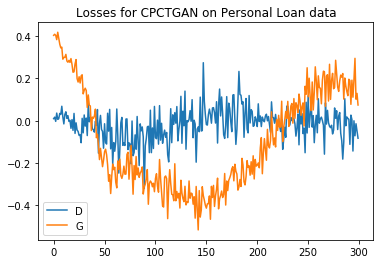

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(dloss)
plt.plot(gloss)
plt.legend(['D', 'G'])
plt.title('Losses for CPCTGAN on Personal Loan data')
#plt.savefig('Original-CTGAN-Adult')

In [121]:
samples['Personal Loan'].value_counts()

0.0    199849
1.0       151
Name: Personal Loan, dtype: int64

In [122]:
GAN_data_train['Personal Loan'].value_counts()

0    3166
1     334
Name: Personal Loan, dtype: int64

In [113]:
#adult_data_all.head()
fake_X = samples.drop(["Personal Loan"],axis=1)
fake_X, fake_y = fake_X,samples.loc[:,"Personal Loan"]

In [114]:
# check the training data shape to agree with the original data (# of features/cols)
print(fake_X.shape)
print(fake_y.shape)
print(orig_X_test.shape)

(200000, 11)
(200000,)
(1500, 11)


In [115]:
# train a classifier on the CPCTGAN generated data
classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

print('ML scores for the GAN generated data:')
for name, clf in zip(names, classifiers):
    clf.fit(fake_X, fake_y)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)

ML scores for the GAN generated data:
Decision Tree Acc:  0.9026666666666666 f-1:  0.0 AUC: 0.6395611177434695
Linear SVM Acc:  0.498 f-1:  0.0026490066225165563 AUC: 0.9250217518868497
Random Forest Acc:  0.9006666666666666 f-1:  0.0 AUC: 0.7168587240242001
Logistic Regression Acc:  0.9026666666666666 f-1:  0.0 AUC: 0.7322696829283099
MLP Acc:  0.278 f-1:  0.2077542062911485 AUC: 0.7832980919042511


The more data that we generate the better the ML utility in this case
200k > 50k > 5k

In [102]:
fake_y.value_counts()

0    4161
1     839
Name: Personal Loan, dtype: int64

In [104]:
orig_y_train.value_counts()

0    3166
1     334
Name: Personal Loan, dtype: int64

In [114]:
sum(y_pred)

0

### Train CTGAN on same data

In [46]:
from ctgan import CTGANSynthesizer

In [47]:
GAN_data_train

,Age,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
4036,46,13,93117,2,0.70,3,0,0,0,1,0,0
2883,40,92,90024,4,1.40,2,0,0,0,1,0,0
4162,61,41,94704,1,0.80,1,0,0,0,1,1,0
4640,30,42,90034,1,2.10,3,0,0,0,1,0,0
2430,23,73,92120,4,2.60,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1593,63,83,91320,3,1.80,2,0,0,0,1,0,0
4060,31,174,93023,2,6.70,1,0,0,0,1,1,0
1346,44,50,95670,3,2.33,1,200,0,0,0,0,0
3454,47,132,92120,1,0.30,1,0,0,0,1,0,0


In [48]:
# train CTGAN and generate fake data
ctgan = CTGANSynthesizer(verbose=True)
ctgan.fit(GAN_data_train, Bank_discrete_columns, epochs=500)

Epoch 1, Loss G:  1.4045,Loss D: -0.1021
Epoch 2, Loss G:  1.6029,Loss D: -0.1705
Epoch 3, Loss G:  1.2130,Loss D: -0.0629
Epoch 4, Loss G:  1.2759,Loss D: -0.0188
Epoch 5, Loss G:  1.1845,Loss D: -0.0335
Epoch 6, Loss G:  1.1846,Loss D:  0.0473
Epoch 7, Loss G:  1.1509,Loss D: -0.0195
Epoch 8, Loss G:  1.2405,Loss D: -0.0527
Epoch 9, Loss G:  1.2715,Loss D: -0.0268
Epoch 10, Loss G:  1.2850,Loss D:  0.0350
Epoch 11, Loss G:  1.3345,Loss D: -0.0609
Epoch 12, Loss G:  1.2989,Loss D: -0.0155
Epoch 13, Loss G:  1.0894,Loss D:  0.0397
Epoch 14, Loss G:  1.1196,Loss D:  0.0172
Epoch 15, Loss G:  1.1021,Loss D:  0.0069
Epoch 16, Loss G:  1.1571,Loss D: -0.0325
Epoch 17, Loss G:  0.9661,Loss D:  0.0343
Epoch 18, Loss G:  0.9943,Loss D:  0.0719
Epoch 19, Loss G:  0.6870,Loss D:  0.0440
Epoch 20, Loss G:  0.7264,Loss D:  0.0512
Epoch 21, Loss G:  0.7991,Loss D:  0.0169
Epoch 22, Loss G:  0.8263,Loss D:  0.0284
Epoch 23, Loss G:  0.7750,Loss D: -0.0141
Epoch 24, Loss G:  0.7246,Loss D: -0.0354
E

Epoch 195, Loss G: -1.2761,Loss D: -0.0474
Epoch 196, Loss G: -1.4595,Loss D:  0.0540
Epoch 197, Loss G: -1.3216,Loss D:  0.0184
Epoch 198, Loss G: -1.3630,Loss D:  0.0650
Epoch 199, Loss G: -1.2664,Loss D: -0.0119
Epoch 200, Loss G: -1.1996,Loss D: -0.0158
Epoch 201, Loss G: -1.3958,Loss D:  0.0612
Epoch 202, Loss G: -1.4010,Loss D:  0.0589
Epoch 203, Loss G: -1.4361,Loss D:  0.0145
Epoch 204, Loss G: -1.4072,Loss D:  0.0014
Epoch 205, Loss G: -1.4988,Loss D:  0.0070
Epoch 206, Loss G: -1.4413,Loss D:  0.0335
Epoch 207, Loss G: -1.4705,Loss D: -0.0264
Epoch 208, Loss G: -1.5045,Loss D: -0.0579
Epoch 209, Loss G: -1.4323,Loss D:  0.0177
Epoch 210, Loss G: -1.4653,Loss D: -0.0063
Epoch 211, Loss G: -1.4691,Loss D: -0.0186
Epoch 212, Loss G: -1.4390,Loss D:  0.0357
Epoch 213, Loss G: -1.5082,Loss D: -0.0951
Epoch 214, Loss G: -1.5193,Loss D:  0.0465
Epoch 215, Loss G: -1.4922,Loss D: -0.0416
Epoch 216, Loss G: -1.5943,Loss D: -0.0598
Epoch 217, Loss G: -1.5275,Loss D:  0.0275
Epoch 218, 

Epoch 386, Loss G: -1.7722,Loss D:  0.0560
Epoch 387, Loss G: -1.7318,Loss D:  0.0317
Epoch 388, Loss G: -1.7545,Loss D: -0.1213
Epoch 389, Loss G: -1.6331,Loss D:  0.0042
Epoch 390, Loss G: -1.7396,Loss D: -0.0668
Epoch 391, Loss G: -1.7636,Loss D:  0.0085
Epoch 392, Loss G: -1.5645,Loss D:  0.0403
Epoch 393, Loss G: -1.6984,Loss D:  0.1162
Epoch 394, Loss G: -1.6737,Loss D: -0.0020
Epoch 395, Loss G: -1.5878,Loss D: -0.1126
Epoch 396, Loss G: -1.6356,Loss D: -0.0360
Epoch 397, Loss G: -1.7114,Loss D: -0.0522
Epoch 398, Loss G: -1.7217,Loss D: -0.0845
Epoch 399, Loss G: -1.6506,Loss D: -0.0443
Epoch 400, Loss G: -1.6994,Loss D:  0.0717
Epoch 401, Loss G: -1.7759,Loss D:  0.0214
Epoch 402, Loss G: -1.8453,Loss D: -0.0304
Epoch 403, Loss G: -1.8846,Loss D: -0.0592
Epoch 404, Loss G: -1.7159,Loss D: -0.0932
Epoch 405, Loss G: -1.7431,Loss D: -0.0735
Epoch 406, Loss G: -1.6647,Loss D:  0.0151
Epoch 407, Loss G: -1.6884,Loss D: -0.0412
Epoch 408, Loss G: -1.6267,Loss D: -0.0515
Epoch 409, 

In [49]:
samples = ctgan.sample(50000)
samples['Personal Loan'].value_counts()

0    42003
1     7997
Name: Personal Loan, dtype: int64

In [50]:
#adult_data_all.head()
fake_X = samples.drop(["Personal Loan"],axis=1)
fake_X, fake_y = fake_X,samples.loc[:,"Personal Loan"]

In [51]:
fake_X

,Age,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
0,44,49,94131,4,1.933614,3,-2,1,1,1,1
1,49,84,92093,4,1.778272,3,0,0,0,1,0
2,53,64,90095,2,3.545648,1,90,0,0,1,0
3,43,169,95825,3,6.247900,3,0,0,0,0,0
4,30,53,92122,4,0.267784,3,97,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
49995,29,124,92672,2,4.922269,3,0,0,0,0,0
49996,48,42,91105,1,0.450360,1,-1,0,0,1,0
49997,50,16,93943,1,3.331141,2,0,1,0,0,1
49998,49,72,92182,2,0.186405,3,0,0,0,1,0


In [52]:
orig_X_test

,Age,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
2648,26,155,93105,2,7.20,1,0,0,0,0,0
2456,54,39,95211,2,0.80,1,0,0,0,0,1
4557,33,30,95054,2,1.00,2,0,0,0,1,0
4884,60,50,95670,3,2.20,3,0,0,0,1,1
92,43,34,94305,3,0.60,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3014,60,40,91311,1,2.50,3,166,0,0,1,0
734,66,53,92182,2,1.10,1,0,0,0,1,1
452,39,21,94022,3,0.20,2,0,0,0,0,0
2558,43,172,95136,2,6.67,1,0,0,0,1,0


In [53]:
# check the training data shape to agree with the original data (# of features/cols)
print(fake_X.shape)
print(fake_y.shape)
print(orig_X_test.shape)

(50000, 11)
(50000,)
(1500, 11)


In [54]:
# train a classifier on the CTGAN generated data
classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

print('ML scores for the GAN generated data:')
for name, clf in zip(names, classifiers):
    clf.fit(fake_X, fake_y)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)

ML scores for the GAN generated data:
Decision Tree Acc:  0.8893333333333333 f-1:  0.5088757396449705 AUC: 0.8989498391372088
Linear SVM Acc:  0.104 f-1:  0.1784841075794621 AUC: 0.9061254325084479
Random Forest Acc:  0.9086666666666666 f-1:  0.5387205387205387 AUC: 0.9264963274721273
Logistic Regression Acc:  0.896 f-1:  0.515527950310559 AUC: 0.9187389975921166
MLP Acc:  0.688 f-1:  0.38421052631578945 AUC: 0.9036947856174502
